[![Open All Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MukundVarmaT/SHAASTRA_FUND_DL/blob/master/GAN/GAN.ipynb)

<h1 align="center">Generative Adversarial Networks</h1>

There are two classes of models: **Generative**, **Discriminative**. Formally,
- Generative models capture the joint probability p(X, Y), or just p(X) if there are no labels.
- Discriminative models capture the conditional probability p(Y | X).

Simply put,
- Generative models can generate new data instances.
- Discriminative models discriminate between different kinds of data instances.

GANs represent on the most exciting recent innovation in deep learning, first introduced by Ian Goodfellow. GAN is all about creating samples which are indistinguishable from their real counterparts. This helps bring machines closer to understanding human intelligence. Lets see a few cool applications of GANs:

- **Image Generation**
https://thispersondoesnotexist.com/

- **Cross-Domain Transfer**
![](assets/cyclegan.gif)

- **Image Style Transfer**
![](assets/stargan.gif)

- **Pose Guided Image Generation**
![](assets/poseguided.gif)

- **Deep Fake**

![](assets/firstorder.gif)

and many many more

## How does it work?

A GAN consists of two networks: A **Generator** and **Discriminator**. 
- Generator: Responsible to map a latent space to the desired output.
- Discriminator: Provides feedback regarding the real/fakeness of the output. (how close it is to a real sample)

**What is a latent space**

Just like in word embeddings, a latent space is a form of representing the output in a specific latent space. Each index of the latent space would represent different features like color, texture, etc of the output (eg: image). This feature mapping is not controlled by us but rather learnt by the model on the fly. We can however build some insights and examine what these features represent after the model is trained. 

## The training process

D (Discriminator), G (Generator)

- D training
    - We need to train the D to distinguish between real and fake samples. This will provide the necessary feedback required to train the G. 
    - Hence the real samples (from the dataset) and fake samples (generated by the G) are passed to the D. The model is trained to classify them.
- G training
    - A random noise is passed as input and the G generates an output (fake output). 
    - Keeping the parameters in D fixed, we pass the fake image as input to G and compute the gradients (i.e) we train the G to create images which the D perceives as real.

## Why a GAN

A common question which might arise is why do we need an adversarial network to generate images. Why can't we train a model to directly regress on the image pixels? 

A normal encoder-decoder model is formally called as an AutoEncoder or AE.

- On training an AE, u are forcing it to generate samples which only exist in the dataset. GANs on the other hand can generate samples which do not belong to the dataset as well. (hence can be abstractively understood as closer to human intelligence)
- AE's tend to average their predictions (i.e) lets assume we have different image samples of chairs each with a different backrest (the design is different). To minimize the loss AEs tend to predict the average of all these samples (which in this case would be a flat backrest with no design). 

In [1]:
import torch.nn as nn
import torch
import torch.optim as optim

# Discriminator
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        leaky_relu = nn.LeakyReLU(0.2)
        dropout = nn.Dropout2d(0.2)
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False),
            leaky_relu,
            dropout,
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
            leaky_relu,
            dropout,
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            leaky_relu,
            dropout,
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            leaky_relu,
            dropout,
            nn.BatchNorm2d(128),
        )
        self.mlp = nn.Linear(128*2*2, 1)
        
    def forward(self, x):
        
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.mlp(x)
        return torch.sigmoid(x)

# Generator
class Generator(nn.Module):
    def __init__(self):
    
        super(Generator, self).__init__()
        relu = nn.ReLU()
        self.mlp = nn.Linear(100, 8*8*128, bias = False)
        self.conv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            relu,
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
            relu,
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
        )
        
    def forward(self, x):
        x = self.mlp(x)
        x = x.reshape(x.shape[0], 128, 8, 8)
        x = self.conv(x)
        return torch.tanh(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator().to(device)
D = Discriminator().to(device)

D_optim = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optim = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

img_size = 32

# img transform and dataset
img_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)), 
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5]) # mnist images are gray scale hence singe channel
])
img_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=img_transform)
img_loader = DataLoader(img_dataset, batch_size=32, shuffle=True, num_workers=4)

In [3]:
def progress_bar(progress=0, status="", bar_len=20):
    status = status.ljust(30)
    block = int(round(bar_len * progress))
    text = "\rProgress: [{}] {}% {}".format(
        "\x1b[32m" + "#" * block + "\033[0m" + "-" * (bar_len - block), round(progress * 100, 2), status
    )
    print(text, end="")
    if progress == 1:
        print("\n")

In [6]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca()
fig.show()

for epoch in range(1, 20+1):
    D_loss_cntr, G_loss_cntr = [], []

    for i, (imgs, _) in enumerate(img_loader):

        imgs = imgs.to(device)        
        real_labels = torch.ones((imgs.shape[0], 1), device=device)
        fake_labels = torch.zeros((imgs.shape[0], 1), device=device)
        latent_vec = torch.randn((imgs.shape[0], 100), device=device)

        # Train D
        real_logits = D(imgs)
        real_loss = criterion(real_logits, real_labels)

        fake_imgs = G(latent_vec)
        fake_logits = D(fake_imgs.detach())
        fake_loss = criterion(fake_logits, fake_labels)

        D_loss = real_loss + fake_loss
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()

        # Train G
        G_loss = criterion(D(fake_imgs), real_labels)

        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()

        D_loss_cntr.append(D_loss.item())
        G_loss_cntr.append(G_loss.item())

        progress_bar(i/len(img_loader), status=f"Epoch: {epoch}, D Loss: {round(np.mean(D_loss_cntr), 3)}, G Loss: {round(np.mean(G_loss_cntr), 3)}")
        
    progress_bar(1, status=f"Epoch: {epoch}, D Loss: {round(np.mean(D_loss_cntr), 3)}, G Loss: {round(np.mean(G_loss_cntr), 3)}")
    torch.save(G.state_dict(), "gan-save.pth")

## GAN Training is not easy!!

- Non convergence: Since the objective is not well defined, there is the high chance that the parameters keep oscillating, destabilize and never converge.
- Mode Collapse: Its very easy for the discriminator to get overfit and hence does not provide the right signal to the generator. This leads to producing noisy samples. 
- Data bias: Unlike classifiers, GANs completely ignore low sampled classes. 
- Maintaining equilibrium between the G and D: Its very easy for one to overpower the other leading to various problems like gradient diminishing, explosion, mode collapse, etc.

## Visualizing and Interpolating the Latent space

In [ ]:
!wget https://github.com/MukundVarmaT/SHAASTRA_FUND_DL/blob/master/GAN/imgcls-save.pth?raw=true
!wget https://github.com/MukundVarmaT/SHAASTRA_FUND_DL/blob/master/GAN/gan-save.pth?raw=true

In [4]:
import torch.nn.functional as F

class Cls(nn.Module):
    def __init__(self):
        super(Cls, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(6*6*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 6*6*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cls = Cls().to(device)
cls.load_state_dict(torch.load("imgcls-save.pth"))

<All keys matched successfully>

In [7]:
G.load_state_dict(torch.load("gan-save.pth"))

latent_vecs = []
img_cls = []

while len(latent_vecs) < 1000:
    latent_vec = torch.randn((32, 100), device=device)

    gen_img = G(latent_vec)
    out = cls(gen_img)
    pred = out.max(1)[1]
    indx = pred<3
    latent_vecs.extend(latent_vec[indx].detach().cpu().numpy())
    img_cls.extend(pred[indx].detach().cpu().numpy())

latent_vecs = np.array(latent_vecs)
img_cls = np.array(img_cls)

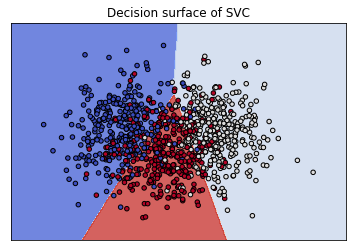

In [8]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

X = latent_vecs
Y = img_cls

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

pca = PCA(n_components=2)
X = pca.fit_transform(X)

model = SVC(kernel='linear')
clf = model.fit(X, Y)

fig, ax = plt.subplots()
title = ('Decision surface of SVC')
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

In [22]:
%config Completer.use_jedi = False
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
import plotly.express as px
import cufflinks as cf
init_notebook_mode(connected = True)

X = latent_vecs
Y = img_cls

indx = Y==0
ref_min = X[indx][10]
indx = Y==2
ref_max = X[indx][10]


def ret_img(step, max_steps):
    vec = ref_min + (step * (ref_max - ref_min)/max_steps)
    vec = torch.tensor(vec).to(device)
    img = G(vec.unsqueeze(0))
    img = img.view([1,32,32])
    img = transforms.ToPILImage()(img).convert('RGB')
    img = list(np.array(img))
    return img

In [23]:
max_steps = 100

fig = go.Figure()

for step in np.arange(0, max_steps, 1):
    fig.add_trace(go.Image(z = ret_img(step, max_steps)))
    
fig.data[10].visible = True

steps = []

for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(i)}]
    )
    step["args"][0]["visible"][i] = True 
    steps.append(step)

sliders = [dict(active=10, currentvalue={"prefix": "Frequency: "}, pad={"t": 50}, steps=steps)]

fig.update_layout(sliders = sliders)

fig.show()

## Mode Collapse

![](assets/ganvis-1.png)
![](assets/ganvis-2.gif)
![](assets/ganvis-3.gif)
![](assets/ganvis-4.png)